In [41]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

from spicy_snow.processing.s1_preprocessing import s1_dB_to_power

from scipy.stats import pearsonr

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [13]:
dss = {fp.stem:xr.open_dataset(fp) for fp in Path('~/scratch/spicy/SnowEx-Data').expanduser().glob('*.nc')}

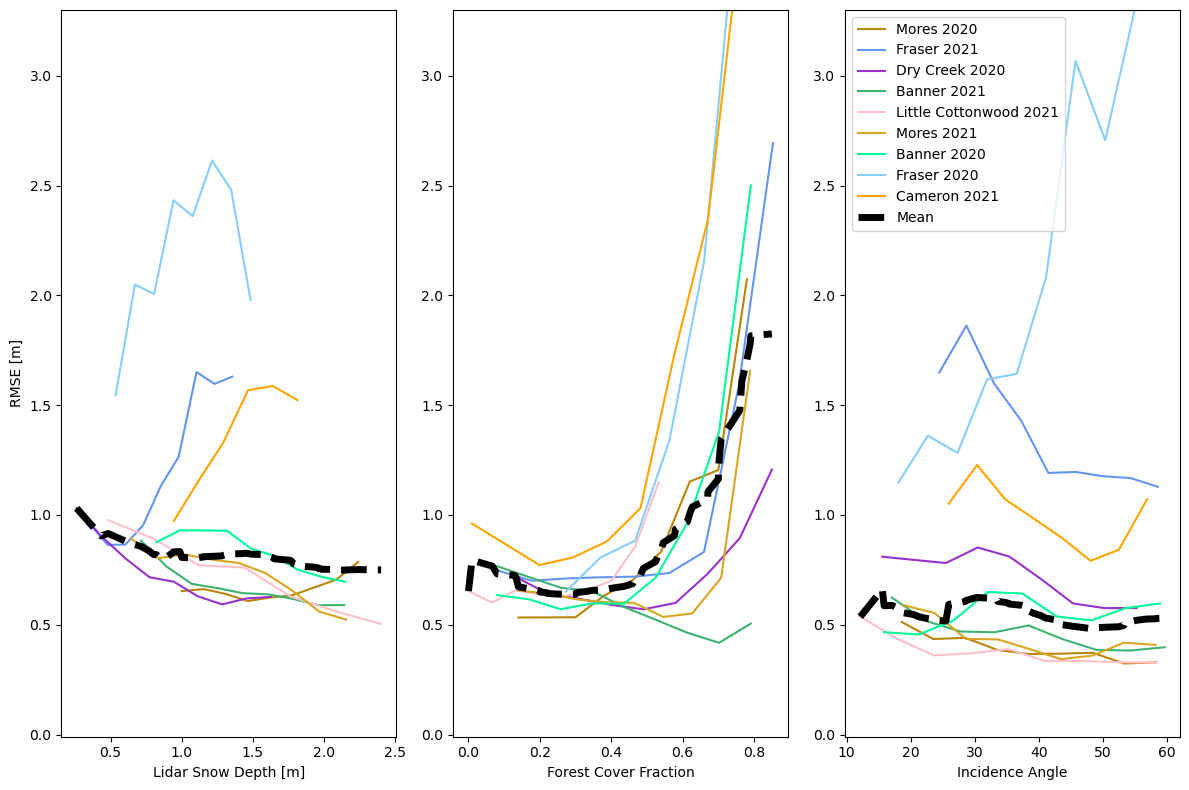

In [205]:
fig, axes = plt.subplots(1, 3, figsize = (12,8))

loc_colors = {'Banner_2020-02-18': 'mediumspringgreen', 'Banner_2021-03-15': 'mediumseagreen', 'Cameron_2021-03-19': 'orange', \
    'Dry_Creek_2020-02-19': 'darkorchid', 'Frasier_2020-02-11': 'lightskyblue', 'Frasier_2021-03-19': 'cornflowerblue', \
        'Little_Cottonwood_2021-03-18': 'pink', 'Mores_2020-02-09': 'darkgoldenrod', 'Mores_2021-03-15': 'goldenrod'}

x_labels = {'lidar-sd': 'Lidar Snow Depth [m]', 'fcf':'Forest Cover Fraction', 's1':'Incidence Angle'} # 'lidar-dem': 'Elevation [m]', , 'lidar-vh': 'Tree Height [m]'

for (var, label), ax in zip(x_labels.items(), axes.ravel()):

    ss = []
    for stem, ds in dss.items():
        # ds = ds.where(ds['wet_snow'] == 0)

        if var == 's1':
            time_ds = ds.sel(band = 'inc')
            time_ds['s1'] = np.abs(np.deg2rad(45) - time_ds['s1'].isel(time = slice(len(np.unique(time_ds.relative_orbit))))).mean(dim = 'time')
            # time_ds = time_ds.where(time_ds['lidar-dem'] > time_ds['lidar-dem'].quantile(0.5))

        if ds.attrs['site'] == 'Frasier' and pd.to_datetime(ds.attrs['lidar-flight-time']).year == 2020:
            time_ds = ds.sel(time = '2020-02-15', method = 'nearest')
        else:
            time_ds = ds.sel(time= ds.attrs['lidar-flight-time'], method ='nearest')
        
        res = pd.Series(dtype = float)

        for cat, sub in time_ds.sel(band = 'inc').groupby_bins(var, np.linspace(*time_ds.sel(band = 'inc')[var].quantile([0.05, 0.95]).values.ravel(), 10)):

            x, y = sub['lidar-sd'].values.ravel(), sub['snow_depth'].values.ravel()
            idx = (~np.isnan(x)) & (~np.isnan(y))

            if len(x[idx]) < 100:
                continue

            stat, p = pearsonr(x[idx], y[idx])
            rmse_result = rmse(x[idx], y[idx]) / np.nanmean(y[idx])

            if var == 's1':
                res.loc[np.rad2deg(cat.left)] = rmse_result / np.nanmean(x)
            elif var == 'lidar-sd':
                res.loc[cat.left] = rmse_result #/ np.nanmean(x)
            else:
                res.loc[cat.left] = rmse_result
                    
        res.sort_index().plot(ax= ax, color = loc_colors[stem], label = stem.split('-')[0].replace('_', ' ').replace('Frasier', 'Fraser'))
        if 'Frasier' not in stem.split('-')[0].replace('_', ' ') or 'Cameron' in stem:
            ss.append(res.sort_index()) 
    
    # add mean line
    # vs = [10, 20, 30, 40,50, 60]
    # ss_new = [s.append(pd.Series({v:np.nan for v in vs})) for s in ss]
    df = pd.concat(ss, axis = 1).sort_index()

    df.interpolate().mean(axis = 1).plot(color = 'black', linewidth = 5, linestyle = 'dashed', ax = ax, label = 'Mean')

    ax.set_xlabel(label)
    ax.set_ylim(-0.01, 3.3)
# axes[0].set_ylabel('NRMSE [m]')
axes[0].set_ylabel('RMSE [m]')
axes[-1].legend()
plt.tight_layout()
plt.savefig('/bsuhome/zacharykeskinen/spicy-analysis/figures/factors/rmse_binned.png')